# KeyWordSpotting - LIVE DEMO

In [1]:
#Imports
import librosa
import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd
import Models #Our models
#.......................

## 1) Audio Input
### Recording from microphone

In [5]:
sr = 16000
seconds = 10

myrec = sd.rec(int(sr*seconds), samplerate=sr, channels=1)
sd.wait()

np.save('LiveDemo/myrec.npy', myrec)

### Reading it from a numpy array

In [ ]:
sr=16000
#myrec = np.load("LiveDemo/ONaudioclip.npy")
myrec = np.load("LiveDemo/myrec.npy")

### Reading it from a wav file

In [ ]:
myrec, sr = librosa.load("LiveDemo/audioclip.wav", sr=None)

### Audio Clip Informations

Sample rate =	16000 samples/s
Duration t =	10.0 s
Average intensity =	 0.0030327137


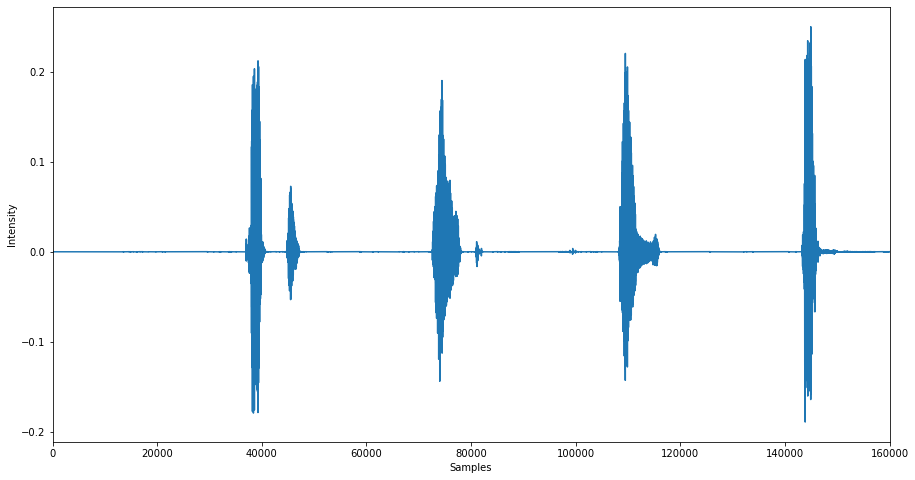

In [6]:
print("Sample rate =\t" + str(sr) + " samples/s")
print("Duration t =\t" + str(len(myrec) / sr) + " s")
print("Average intensity =\t",np.mean(np.abs(myrec)))

# Play it
play = True
if play:
    sd.play(myrec, sr)
    
# Plot
plt.figure(figsize=(15, 8))
plt.plot(myrec)
plt.xlabel("Samples")
plt.ylabel("Intensity")
plt.xlim(0, len(myrec))
plt.show()

## 2) Load Model

## 3) ...

### Silince Filter

In [ ]:
#......

### Sliding Window
A 1 second window will slide left to right with a step of 1600 samples (100ms) in order to have 10 windows per second 



Number of windows: 19
Step: 8000
(19, 16000, 1)
(19, 1)
Window 0 Silence 1.667022705078125e-05
Window 1 Silence 2.8598785400390625e-05
Window 2 Silence 2.9832839965820313e-05
Window 3 Pred 0.005138650894165039
Window 4 Pred 0.006902935028076172
Window 5 Pred 0.0017948856353759766
Window 6 Silence 3.1078338623046876e-05
Window 7 Silence 3.135490417480469e-05
Window 8 Pred 0.007533163070678711
Window 9 Pred 0.007622289657592774
Window 10 Silence 0.000122802734375
Window 11 Silence 6.762123107910157e-05
Window 12 Pred 0.007120746612548828
Window 13 Pred 0.008581226348876952
Window 14 Pred 0.0015256614685058593
Window 15 Silence 2.9052734375e-05
Window 16 Pred 0.0012973880767822266
Window 17 Pred 0.007005496978759766
Window 18 Pred 0.005746858596801758


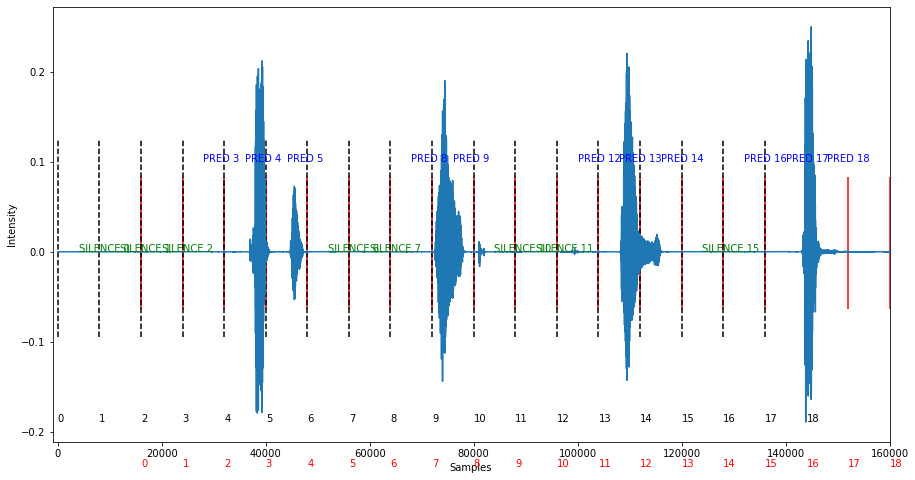

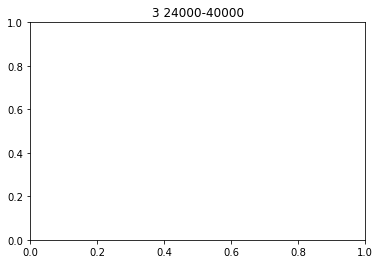

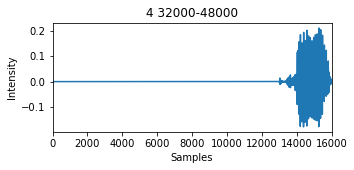

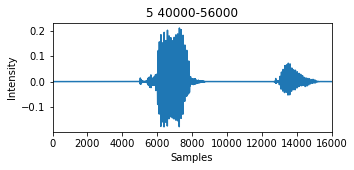

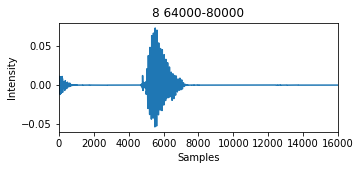

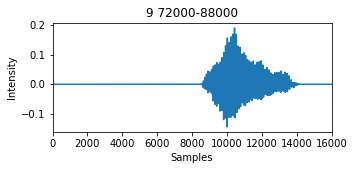

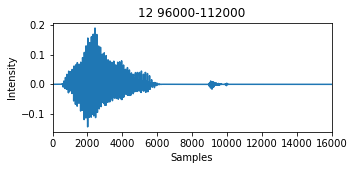

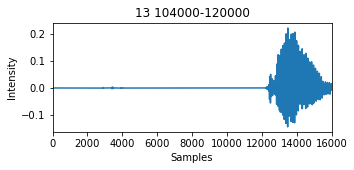

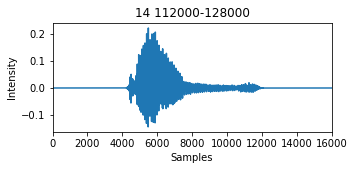

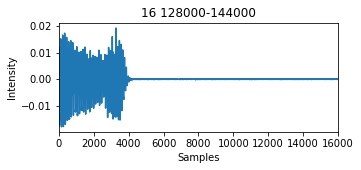

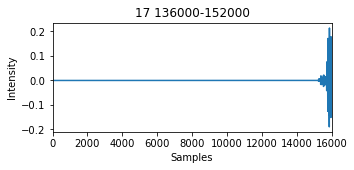

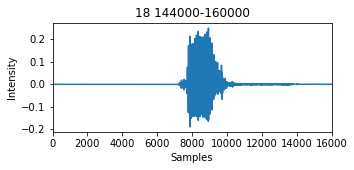

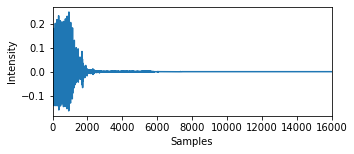

In [24]:
if len(myrec.shape)<2: myrec=myrec[...,np.newaxis] # for the 1 sec audios

ws=2 #windows per second

step=int(sr/ws)
nwin=int((len(myrec)-sr)/step)+1 #number of windows
windows=np.empty((nwin,sr,1))
predictions=np.empty((nwin,1))

print("Number of windows:",nwin)
print("Step:",step)
print(windows.shape)
print(predictions.shape)

#divide in windows
for i in range(nwin):
    start=int(i*step)
    end=int(start+sr)
    windows[i]=myrec[start:end]

    
# Plot
plt.figure(figsize=(15, 8))
plt.plot(myrec)
plt.xlabel("Samples")
plt.ylabel("Intensity")
plt.xlim(-1000, len(myrec))


for i in range(nwin):
    start=int(i*step)
    plt.vlines(start, np.min(myrec)/2, np.max(myrec)/2, colors='k',linestyles='dashed')
    plt.vlines(start+sr, np.min(myrec)/3, np.max(myrec)/3, colors='r')
    plt.text(start, np.min(myrec), i)
    plt.text(start+sr, np.min(myrec)-0.05, i, color='red')
    
    #SILENCE FILTER
    if np.mean(np.abs(windows[i]))<(10**-3):
        predictions[i]=-1 #Silence
        plt.text(start+sr/4, 0, "SILENCE "+str(i), color='green')
        print("Window",i,"Silence",np.mean(np.abs(windows[i])))
    else:
        #predictions[i]=model.predict(windows[i])
        plt.text(start+sr/4, 0.1, "PRED "+str(i), color='blue')
        print("Window",i,"Pred",np.mean(np.abs(windows[i])))

plt.show()



voice=[] #indeces
for i in range(len(predictions)):
    if predictions[i]!=-1:
        voice.append(i)
        plt.title(str(i)+" "+str(int(i*step))+"-"+str(int(i*step)+sr))
        plt.figure(figsize=(5,2))
        plt.plot(windows[i])
        plt.xlabel("Samples")
        plt.ylabel("Intensity")
        plt.xlim(0, len(windows[i]))

plt.show()



### Fusion Rule

In [ ]:
#....